In [ ]:
from pathlib import Path
from scipy.io import loadmat
import sys
import os


dataset_path = Path('data') / 'data.mat'
if not dataset_path.exists():
    alt = Path.cwd().parent / 'data' / 'data.mat'
    if alt.exists():
        dataset_path = alt
    else:
        raise FileNotFoundError(f"data.mat not found under {Path.cwd()} or its parent")

notebook_path = os.getcwd() 
print (f"Current notebook path: {notebook_path}")
project_root = os.path.dirname(notebook_path)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print (f"Added {project_root} to sys.path")

mat_data = loadmat(dataset_path)
print(mat_data.keys())

In [2]:
import torch
import matplotlib.pyplot as plt
from utils import trainer
from utils import utils
from Systems import DynamicSystem
import Filters
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
import random

# Set reproducible seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Currently used device: {device}")

Currently used device: cpu


/home/luky/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
mat_data = loadmat(dataset_path)

souradniceX_mapa = mat_data['souradniceX']
souradniceY_mapa = mat_data['souradniceY']
souradniceZ_mapa = mat_data['souradniceZ']
souradniceGNSS = mat_data['souradniceGNSS'] 
x_axis_unique = souradniceX_mapa[0, :]
y_axis_unique = souradniceY_mapa[:, 0]

print(f"Dimensions of 1D X axis: {x_axis_unique.shape}")
print(f"Dimensions of 1D Y axis: {y_axis_unique.shape}")
print(f"Dimensions of 2D elevation data Z: {souradniceZ_mapa.shape}")


terMap_interpolator = RegularGridInterpolator(
    (y_axis_unique, x_axis_unique),
    souradniceZ_mapa,
    bounds_error=False, 
    fill_value=np.nan
)

def terMap(px, py):
    # Query bilinear interpolation over the terrain map
    points_to_query = np.column_stack((py, px))
    return terMap_interpolator(points_to_query)

Dimensions of 1D X axis: (2500,)
Dimensions of 1D Y axis: (2500,)
Dimensions of 2D elevation data Z: (2500, 2500)


# 4D model

### The map is shifted

In [4]:
import torch
import torch.nn.functional as func
from Systems import DynamicSystemTAN

# Safe device selection with fallback
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Using device: {device}")

# Get global offset from first GNSS point (start at 0,0)
global_offset_x = souradniceGNSS[0, 0]
global_offset_y = souradniceGNSS[1, 0]

# Original map axes
x_axis_unique = souradniceX_mapa[0, :]
y_axis_unique = souradniceY_mapa[:, 0]

# Shifted map bounds (in local frame where start is 0,0)
x_min_shifted = x_axis_unique.min() - global_offset_x
x_max_shifted = x_axis_unique.max() - global_offset_x
y_min_shifted = y_axis_unique.min() - global_offset_y
y_max_shifted = y_axis_unique.max() - global_offset_y

print(f"Local map bounds X: [{x_min_shifted:.2f}, {x_max_shifted:.2f}]")
print(f"Local map bounds Y: [{y_min_shifted:.2f}, {y_max_shifted:.2f}]")

# Prepare the map tensor; fallback to CPU if CUDA is busy/unavailable
try:
    terMap_tensor = torch.from_numpy(souradniceZ_mapa).float().unsqueeze(0).unsqueeze(0)
    terMap_tensor = terMap_tensor.to(device)
except RuntimeError as e:
    print("Warning: CUDA unavailable or busy. Falling back to CPU for terMap_tensor.")
    print(f"Reason: {e}")
    device = torch.device("cpu")
    terMap_tensor = terMap_tensor.cpu()

state_dim = 4
obs_dim = 3
dT = 1.0
q = 1.0

F = torch.tensor([[1.0, 0.0, dT, 0.0],
                  [0.0, 1.0, 0.0, dT],
                  [0.0, 0.0, 1.0, 0.0],
                  [0.0, 0.0, 0.0, 1.0]], device=device)

Q = q * torch.tensor([[dT**3/3, 0.0,     dT**2/2, 0.0],
                      [0.0,     dT**3/3, 0.0,     dT**2/2],
                      [dT**2/2, 0.0,     dT,      0.0],
                      [0.0,     dT**2/2, 0.0,     dT]], device=device)

R = torch.tensor([[3.0**2, 0.0,    0.0],
                  [0.0,    1.0**2, 0.0],
                  [0.0,    0.0,    1.0**2]], device=device)

x_0 = torch.zeros(state_dim, device=device).float()
print("Initial state x_0:", x_0)

# Initial error covariance P_0
P_0 = torch.tensor([[25.0, 0.0, 0.0, 0.0],
                    [0.0, 25.0, 0.0, 0.0],
                    [0.0, 0.0, 0.5, 0.0],
                    [0.0, 0.0, 0.0, 0.5]], device=device)

def h_nl_differentiable(x: torch.Tensor, map_tensor, x_min, x_max, y_min, y_max) -> torch.Tensor:
    """
    Maps state x -> measurement y.
    x: [Batch, 4] (px, py, vx, vy)
    Output: [Batch, 3] (z_baro, v_world_x, v_world_y)
    """
    batch_size = x.shape[0]
    
    # 1. Extract position
    px = x[:, 0]
    py = x[:, 1]

    # 2. Normalize coordinates for grid_sample to interval [-1, 1]
    px_norm = 2.0 * (px - x_min) / (x_max - x_min) - 1.0
    py_norm = 2.0 * (py - y_min) / (y_max - y_min) - 1.0

    # Prepare grid [Batch, 1, 1, 2]
    sampling_grid = torch.stack((px_norm, py_norm), dim=1).view(batch_size, 1, 1, 2)

    vyska_terenu_batch = func.grid_sample(
        map_tensor.expand(batch_size, -1, -1, -1), # duplicate map for batch
        sampling_grid, 
        mode='bilinear', 
        padding_mode='border',
        align_corners=True
    )
    vyska_terenu = vyska_terenu_batch.view(batch_size)

    vx_w, vy_w = x[:, 2], x[:, 3]
    
    eps = 1e-12
    norm_v_w = torch.sqrt(vx_w**2 + vy_w**2).clamp(min=eps)
    
    # Cos and Sin of heading angle
    cos_psi = vx_w / norm_v_w
    sin_psi = vy_w / norm_v_w

    # Rotate velocity
    vx_b = cos_psi * vx_w - sin_psi * vy_w  
    vy_b = sin_psi * vx_w + cos_psi * vy_w 
    
    result = torch.stack([vyska_terenu, vx_b, vy_b], dim=1)
    return result

h_wrapper = lambda x: h_nl_differentiable(
    x, 
    map_tensor=terMap_tensor, 
    x_min=x_min_shifted, 
    x_max=x_max_shifted, 
    y_min=y_min_shifted, 
    y_max=y_max_shifted
)

system_model = DynamicSystemTAN(
    state_dim=state_dim,
    obs_dim=obs_dim,
    Q=Q,
    R=R,
    Ex0=x_0,
    P0=P_0,
    F=F,
    h=h_wrapper,
    x_axis_unique=torch.tensor([x_min_shifted, x_max_shifted], device=device),
    y_axis_unique=torch.tensor([y_min_shifted, y_max_shifted], device=device),
    device=device
)

Using device: cpu
Local map bounds X: [-10935.76, 1994.30]
Local map bounds Y: [-11487.78, 4920.93]
Initial state x_0: tensor([0., 0., 0., 0.])
INFO: DynamicSystemTAN inicializován s hranicemi mapy:
  X: [-10935.76, 1994.30]
  Y: [-11487.78, 4920.93]


### Grafické ověření
ověření, že funkce h je správně definována a mapa je správně posunuta.

Rendering 3D plot...


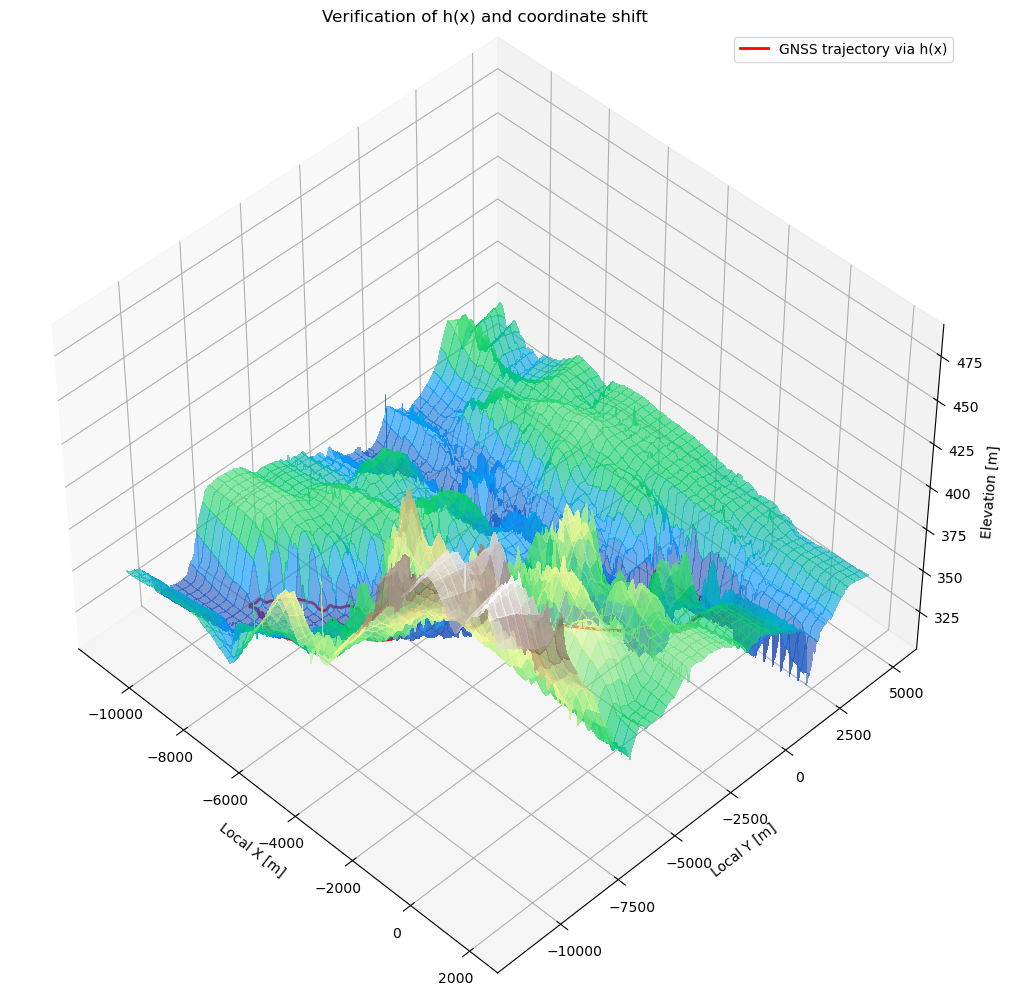

Done.
Elevation range along trajectory: 315.30 m to 402.06 m


In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch


def verify_map_alignment_3d(gnss_data, map_x, map_y, map_z, model, x_offset, y_offset, downsample=10):
    gnss_x_global = gnss_data[0, :]
    gnss_y_global = gnss_data[1, :]
    
    # Transform to local frame (same as during training)
    local_px = gnss_x_global - x_offset
    local_py = gnss_y_global - y_offset
    
    N = len(local_px)
    
    dummy_vx = np.ones(N)
    dummy_vy = np.zeros(N)
    
    # Build tensor [N, 4]
    x_states_np = np.stack([local_px, local_py, dummy_vx, dummy_vy], axis=1)
    x_states = torch.from_numpy(x_states_np).float().to(model.device)
    
    # If h is an nn.Module, switch to eval
    model.h.eval() if hasattr(model.h, 'eval') else None
    with torch.no_grad():
        y_out = model.h(x_states)
        
    calculated_heights = y_out[:, 0].cpu().numpy()
    
    if map_x.ndim == 1 and map_y.ndim == 1 and map_z.ndim == 2:
         # If map_x/y are axes only, create meshgrid for plotting
         X_grid, Y_grid = np.meshgrid(map_x, map_y)  # Watch ordering: Z[row, col] -> Y[row], X[col]
         if map_z.shape == (len(map_y), len(map_x)):
             pass
         elif map_z.shape == (len(map_x), len(map_y)):
             X_grid, Y_grid = np.meshgrid(map_x, map_y, indexing='ij')
    else:
        X_grid, Y_grid = map_x, map_y
        
    # Shift map to local coordinates
    X_grid_local = X_grid - x_offset
    Y_grid_local = Y_grid - y_offset
    Z_grid = map_z
    
    # Downsample for faster plotting (map may be huge)
    ds = downsample
    X_plot = X_grid_local[::ds, ::ds]
    Y_plot = Y_grid_local[::ds, ::ds]
    Z_plot = Z_grid[::ds, ::ds]
    
    # Plot
    print("Rendering 3D plot...")
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    surf = ax.plot_surface(X_plot, Y_plot, Z_plot, cmap='terrain', alpha=0.6, linewidth=0, antialiased=False)

    ax.plot(local_px, local_py, calculated_heights, color='red', linewidth=2, label='GNSS trajectory via h(x)')
    
    ax.set_title('Verification of h(x) and coordinate shift')
    ax.set_xlabel('Local X [m]')
    ax.set_ylabel('Local Y [m]')
    ax.set_zlabel('Elevation [m]')
    ax.legend()
    
    ax.view_init(elev=45, azim=-45)
    
    plt.tight_layout()
    plt.show()
    
    print("Done.")
    print(f"Elevation range along trajectory: {calculated_heights.min():.2f} m to {calculated_heights.max():.2f} m")

verify_map_alignment_3d(
    souradniceGNSS, 
    x_axis_unique,
    y_axis_unique, 
    souradniceZ_mapa, 
    system_model, 
    global_offset_x, 
    global_offset_y,
    downsample=1 
)

## Data Generation
### Data are generated from zero initial conditions

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from utils import utils

# --- CONFIGURATION ---
TRAIN_SEQ_LEN = 300
VALID_SEQ_LEN = 400

NUM_TRAIN_TRAJECTORIES = 700  # Total number of training trajectories
NUM_VALID_TRAJECTORIES = 100  # Total number of validation trajectories
BATCH_SIZE = 256

# Map bounds propagated to system model
system_model.min_x = x_min_shifted
system_model.max_x = x_max_shifted
system_model.min_y = y_min_shifted
system_model.max_y = y_max_shifted
system_model.device = device 

print(f"\n=== Generating {NUM_TRAIN_TRAJECTORIES} TRAINING trajectories (length {TRAIN_SEQ_LEN}) ===")

x_train, y_train = utils.generate_data_for_map(
    system_model, 
    num_trajectories=NUM_TRAIN_TRAJECTORIES, 
    seq_len=TRAIN_SEQ_LEN,
    force_initial_state_zero=True
)

print(f"--> Done. Training data: X={x_train.shape}, Y={y_train.shape}")


print(f"\n=== Generating {NUM_VALID_TRAJECTORIES} VALIDATION trajectories (length {VALID_SEQ_LEN}) ===")

x_val, y_val = utils.generate_data_for_map(
    system_model, 
    num_trajectories=NUM_VALID_TRAJECTORIES, 
    seq_len=VALID_SEQ_LEN,
    force_initial_state_zero=True
)

print(f"--> Done. Validation data: X={x_val.shape}, Y={y_val.shape}")


train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("\n✅ DataLoaders ready. Sets removed; using total trajectory counts.")
print(f"Range of training X (min/max): {x_train.min():.2f} / {x_train.max():.2f}")


=== Generating 700 TRAINING trajectories (length 300) ===
INFO: Generátor dat používá hranice X:[-10935.76-1994.30], Y:[-11487.78-4920.93]
INFO: Vynucený start v nule: True
  Úspěšně vygenerována trajektorie 70/700 (Pokusů: 97)
  Úspěšně vygenerována trajektorie 70/700 (Pokusů: 97)
  Úspěšně vygenerována trajektorie 140/700 (Pokusů: 189)
  Úspěšně vygenerována trajektorie 140/700 (Pokusů: 189)
  Úspěšně vygenerována trajektorie 210/700 (Pokusů: 268)
  Úspěšně vygenerována trajektorie 210/700 (Pokusů: 268)
  Úspěšně vygenerována trajektorie 280/700 (Pokusů: 357)
  Úspěšně vygenerována trajektorie 280/700 (Pokusů: 357)
  Úspěšně vygenerována trajektorie 350/700 (Pokusů: 447)
  Úspěšně vygenerována trajektorie 350/700 (Pokusů: 447)
  Úspěšně vygenerována trajektorie 420/700 (Pokusů: 563)
  Úspěšně vygenerována trajektorie 420/700 (Pokusů: 563)
  Úspěšně vygenerována trajektorie 490/700 (Pokusů: 663)
  Úspěšně vygenerována trajektorie 490/700 (Pokusů: 663)


## Plot Training Trajectories

In [ ]:
import matplotlib.pyplot as plt


def plot_trajectories(x_data, title="Trajectories", num_to_plot=None):
    # Convert to numpy for matplotlib
    x_np = x_data.detach().cpu().numpy()
    
    total_traj = x_np.shape[0]
    
    # Select indices to plot
    if num_to_plot is not None and num_to_plot < total_traj:
        indices = np.random.choice(total_traj, num_to_plot, replace=False)
        print(f"Plotting {num_to_plot} random trajectories out of {total_traj} total.")
    else:
        indices = range(total_traj)
        print(f"Plotting all {total_traj} trajectories.")

    plt.figure(figsize=(10, 8))
    
    for i in indices:
        # x_np[i, :, 0] is X coordinate over time
        # x_np[i, :, 1] is Y coordinate over time
        pos_x = x_np[i, :, 0]
        pos_y = x_np[i, :, 1]
        
        # Plot path
        plt.plot(pos_x, pos_y, alpha=0.5, linewidth=1)
        
        # Highlight start (green dot) and end (red dot)
        plt.plot(pos_x[0], pos_y[0], 'go', markersize=3, label='Start' if i == (indices[0] if hasattr(indices, '__getitem__') else 0) else "")
        plt.plot(pos_x[-1], pos_y[-1], 'ro', markersize=3, label='End' if i == (indices[0] if hasattr(indices, '__getitem__') else 0) else "")

    plt.title(title)
    plt.xlabel("Position X [m]")
    plt.ylabel("Position Y [m]")
    plt.grid(True)
    plt.axis('equal')  # Avoid aspect ratio distortion
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# 1. Plot all training data (may be cluttered if too many)
plot_trajectories(x_train, title="All training trajectories (from zero)")

# 2. Or plot a random sample (e.g., 50 trajectories) for clarity
# plot_trajectories(x_train, title="Sample of 50 training trajectories", num_to_plot=50)

# 3. You can also check validation data
# plot_trajectories(x_val, title="Validation trajectories", num_to_plot=20)

In [ ]:
import torch


def calculate_naive_baseline(x_train, x_val):
    # Mean of states across all trajectories and timesteps
    train_mean = torch.mean(x_train, dim=(0, 1))
    
    print("Mean of states (Naive prediction):")
    print(f"  Position:  {train_mean[0:2].tolist()}")
    print(f"  Velocity:  {train_mean[2:4].tolist()}")

    errors_squared = (x_val - train_mean) ** 2
    
    mse_pos = torch.mean(errors_squared[:, :, 0:2]).item()
    mse_vel = torch.mean(errors_squared[:, :, 2:4]).item()
    mse_total = torch.mean(errors_squared).item()
    
    print("---------------------------------------------------")
    print(f"Baseline Loss (Total): {mse_total:.6f}  (for comparison with validation loss during training)")
    print("---------------------------------------------------")
    print(f"  > Position MSE:  {mse_pos:.6f}")
    print(f"  > Velocity MSE:  {mse_vel:.6f}")
    
    return mse_total, mse_pos, mse_vel

base_loss, base_pos, base_vel = calculate_naive_baseline(x_train, x_val)

### KalmanNet Training

Notes:
- During training, for each new trajectory, KalmanNet receives the exact initial state via `reset()`.
- The output layer `output_final_linear` is initialized with near-zero weights to reduce extreme loss spikes at the beginning of training.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import random
from copy import deepcopy
from state_NN_models import StateKalmanNet 
from state_NN_models import StateKalmanNet_arch2
from utils import trainer 

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

if False:
    # Use architecture 2: model with 3 distinct GRU layers
    state_knet2 = StateKalmanNet_arch2(
        system_model=system_model, 
        device=device,
        hidden_size_multiplier=12,
        output_layer_multiplier=4
        ).to(device)
else:
    # Use architecture 1: model with a single GRU layer
    state_knet2 = StateKalmanNet(
        system_model=system_model, 
        device=device,
        hidden_size_multiplier=10,
        output_layer_multiplier=1,
        num_gru_layers=1,
        gru_hidden_dim_multiplier=8
        ).to(device)

print(state_knet2)

trained_model = trainer.train_state_KalmanNet_sliding_window(
    model=state_knet2,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=500,
    lr=1e-4,
    clip_grad=10.0,
    early_stopping_patience=200,
    tbptt_k=2,
    tbptt_w=30,
    optimizer_=torch.optim.AdamW,
    weight_decay_=1e-5,

)
print(trained_model)
# New best model saved! Epoch [28/500], Train Loss: 47.183285, Val Loss: 115.5970380

In [ ]:
import torch
import matplotlib.pyplot as plt


def verify_dead_reckoning_hypothesis(model, val_loader, device, dt=1.0):
    model.eval()
    
    pos_mse_knet = 0.0
    pos_mse_dr = 0.0
    total_samples = 0
    
    # For visualization, store the first trajectory from the batch
    traj_gt = []
    traj_knet = []
    traj_dr = []
    
    with torch.no_grad():
        for i, (x_true, y_meas) in enumerate(val_loader):
            x_true = x_true.to(device)
            y_meas = y_meas.to(device)
            batch_size, seq_len, _ = x_true.shape
            
            # --- 1. KalmanNet prediction ---
            model.reset(batch_size=batch_size, initial_state=x_true[:, 0, :])
            knet_preds = []
            for t in range(1, seq_len):
                out = model.step(y_meas[:, t, :])
                # Handle tuple output for Architecture 2
                state = out[0] if isinstance(out, tuple) else out
                knet_preds.append(state)
            knet_tensor = torch.stack(knet_preds, dim=1)  # [B, T-1, 4]
            
            # --- 2. Dead Reckoning (simulate a "dumb" integrator) ---
            # Start at the correct position at t=0
            dr_pos = x_true[:, 0, 0:2].clone()
            dr_preds = []
            
            for t in range(1, seq_len):
                # y_meas[:, t, 1] is vx, y_meas[:, t, 2] is vy (assuming world-frame measurement)
                vx_meas = y_meas[:, t, 1]
                vy_meas = y_meas[:, t, 2]
                
                # Euler integration: pos = pos + vel * dt
                dr_pos[:, 0] += vx_meas * dt
                dr_pos[:, 1] += vy_meas * dt
                dr_preds.append(dr_pos.clone())
            
            dr_tensor = torch.stack(dr_preds, dim=1)  # [B, T-1, 2]
            
            # --- 3. Error computation ---
            # Ground-truth position (from t=1)
            gt_pos = x_true[:, 1:, 0:2]
            
            # MSE for KalmanNet (position)
            knet_err = (knet_tensor[:, :, 0:2] - gt_pos) ** 2
            pos_mse_knet += knet_err.sum().item()
            
            # MSE for Dead Reckoning (position)
            dr_err = (dr_tensor - gt_pos) ** 2
            pos_mse_dr += dr_err.sum().item()
            
            total_samples += (batch_size * (seq_len - 1))
            
            # Save first trajectory for plotting (only from first batch)
            if i == 0:
                traj_gt = x_true[0, :, 0:2].cpu().numpy()
                traj_knet = torch.cat([x_true[0:1, 0, 0:2], knet_tensor[0, :, 0:2]], dim=0).cpu().numpy()
                traj_dr = torch.cat([x_true[0:1, 0, 0:2], dr_tensor[0, :, :]], dim=0).cpu().numpy()

    avg_mse_knet = pos_mse_knet / total_samples
    avg_mse_dr = pos_mse_dr / total_samples
    
    print("\n=== HYPOTHESIS VERIFICATION: IGNORING THE MAP ===")
    print(f"Position MSE (Dead Reckoning - pure integration): {avg_mse_dr:.2f}")
    print(f"Position MSE (KalmanNet - your model):           {avg_mse_knet:.2f}")
    
    ratio = avg_mse_knet / avg_mse_dr
    print(f"Ratio (KNet / DR): {ratio:.4f}")
    
    if 0.95 < ratio < 1.05:
        print(">> CONFIRMED: Model behaves almost identically to Dead Reckoning. It ignores the map.")
    elif ratio < 0.9:
        print(">> REJECTED: Model is more than 10% better than DR. It uses the map.")
    else:
        print(">> UNCLEAR: Model is somewhat different, but not by much.")

    return traj_gt, traj_knet, traj_dr

# Run
gt_plot, knet_plot, dr_plot = verify_dead_reckoning_hypothesis(state_knet2, val_loader, device)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.plot(gt_plot[:, 0], gt_plot[:, 1], 'k-', label='Ground Truth', linewidth=2)
plt.plot(dr_plot[:, 0], dr_plot[:, 1], 'r--', label='Dead Reckoning (No map)')
plt.plot(knet_plot[:, 0], knet_plot[:, 1], 'b-.', label='KalmanNet Prediction')
plt.legend()
plt.title("Model behavior analysis: Does it follow the map or just integrate?")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.grid(True)
plt.axis('equal')
plt.show()

## Testing on Test Data
- Comparison of KalmanNet against UKF and PF
- PF would require roughly 10x more particles for higher accuracy; not explored here

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

TEST_SEQ_LEN = 1000
NUM_TEST_TRAJ = 5

print(f"\nGenerating {NUM_TEST_TRAJ} test trajectories of length {TEST_SEQ_LEN}...")

x_test, y_test = utils.generate_data_for_map(
    system_model, 
    num_trajectories=NUM_TEST_TRAJ,
    seq_len=TEST_SEQ_LEN,
    force_initial_state_zero=True
)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print("Data generation complete.")

print("y shape:", y_test.shape)  # Should be [N, T, obs_dim]
print("x shape:", x_test.shape)  # Should be [N, T, state_dim]

ukf_ideal = Filters.UnscentedKalmanFilter(system_model)
pf_sir_ideal = Filters.ParticleFilter(system_model, num_particles=20000)

all_x_true_cpu = []
all_x_hat_ukf_ideal_cpu, all_P_hat_ukf_ideal_cpu = [], []
all_x_hat_pf_sir_ideal_cpu, all_P_hat_pf_sir_ideal_cpu = [], []
all_x_hat_classic_knet_cpu = []
all_x_hat_bkn_cpu, all_P_hat_bkn_cpu = [], []
all_x_hat_knet_cpu = []
all_x_hat_classic_knet2_cpu = []
all_x_hat_classic_knet3_cpu = []
all_x_hat_kalman_former_cpu = []

all_knet_diagnostics_cpu = []
print(f"\nEvaluating models on {NUM_TEST_TRAJ} test trajectories...")

state_knet2.eval()

with torch.no_grad():
    for i, (x_true_seq_batch, y_test_seq_batch) in enumerate(test_loader):
        y_test_seq_gpu = y_test_seq_batch.squeeze(0).to(device)
        x_true_seq_gpu = x_true_seq_batch.squeeze(0).to(device)
        initial_state = x_true_seq_gpu[0, :].unsqueeze(0)
        state_knet2.reset(batch_size=1, initial_state=initial_state)
        classic_knet2_preds = []
        for t in range(1, TEST_SEQ_LEN):
            x_filtered_t = state_knet2.step(y_test_seq_gpu[t, :].unsqueeze(0))
            classic_knet2_preds.append(x_filtered_t)
        full_x_hat_classic_knet2 = torch.cat([initial_state, torch.cat(classic_knet2_preds, dim=0)], dim=0)

        ukf_i_res = ukf_ideal.process_sequence(
            y_seq=y_test_seq_gpu,
            Ex0=system_model.Ex0, 
            P0=system_model.P0
        )
        full_x_hat_ukf_i = ukf_i_res['x_filtered']
        full_P_hat_ukf_i = ukf_i_res['P_filtered']

        pf_sir_i_res = pf_sir_ideal.process_sequence(y_test_seq_gpu, Ex0=system_model.Ex0,P0=system_model.P0)
        full_x_hat_pf_sir_i = pf_sir_i_res['x_filtered']
        full_P_hat_pf_sir_i = pf_sir_i_res['P_filtered']
        full_particles_history_pf_sir_i = pf_sir_i_res['particles_history']
        print(f"PF-SIR (ideal model) finished for trajectory {i + 1}/{NUM_TEST_TRAJ}.")

        all_x_true_cpu.append(x_true_seq_gpu.cpu())
        all_x_hat_classic_knet2_cpu.append(full_x_hat_classic_knet2.cpu())
        all_x_hat_ukf_ideal_cpu.append(full_x_hat_ukf_i.cpu()); all_P_hat_ukf_ideal_cpu.append(full_P_hat_ukf_i.cpu())
        all_x_hat_pf_sir_ideal_cpu.append(full_x_hat_pf_sir_i.cpu()); all_P_hat_pf_sir_ideal_cpu.append(full_P_hat_pf_sir_i.cpu())
        print(f"Completed trajectory {i + 1}/{NUM_TEST_TRAJ}...")

mse_bkn, anees_bkn = [], []; mse_ukf_ideal, anees_ukf_ideal = [], []

mse_pf_sir_ideal, anees_pf_sir_ideal = [], []
mse_classic_knet2 = []; mse_classic_knet3 = []
mse_kalman_former = []

with torch.no_grad():
    for i in range(NUM_TEST_TRAJ):
        x_true = all_x_true_cpu[i]
        def get_metrics(x_hat_full, P_hat_full):
            if x_hat_full.shape[0] != x_true.shape[0] or P_hat_full.shape[0] != x_true.shape[0]:
                 raise ValueError(f"Length mismatch! x_true: {x_true.shape[0]}, x_hat: {x_hat_full.shape[0]}, P_hat: {P_hat_full.shape[0]}")

            mse = F.mse_loss(x_hat_full[1:], x_true[1:]).item()

            anees = utils.calculate_anees_vectorized(
                x_true[1:].unsqueeze(0),
                x_hat_full[1:].unsqueeze(0),
                P_hat_full[1:].unsqueeze(0)
            )
            return mse, anees

        mse = F.mse_loss(all_x_hat_classic_knet2_cpu[i][1:], x_true[1:]).item(); mse_classic_knet2.append(mse)
        mse, anees = get_metrics(all_x_hat_ukf_ideal_cpu[i], all_P_hat_ukf_ideal_cpu[i]); mse_ukf_ideal.append(mse); anees_ukf_ideal.append(anees)
        mse, anees = get_metrics(all_x_hat_pf_sir_ideal_cpu[i], all_P_hat_pf_sir_ideal_cpu[i]); mse_pf_sir_ideal.append(mse); anees_pf_sir_ideal.append(anees)
        print("\n" + "="*80)
        print(f"trajectory: {i + 1}/{NUM_TEST_TRAJ}")
        print("="*80)
        print("-" * 80)
        print(f"{'KNet2 (MSE only)':<35} | {(mse_classic_knet2[i]):<20.4f} | {'N/A':<20}")
        print(f"{'UKF (Ideal model)':<35} | {(mse_ukf_ideal[i]):<20.4f} | {(anees_ukf_ideal[i]):<20.4f}")
        print(f"{'PF-SIR (Ideal model)':<35} | {(mse_pf_sir_ideal[i]):<20.4f} | {(anees_pf_sir_ideal[i]):<20.4f}")
        print("="*80)
      
def avg(metric_list): return np.mean([m for m in metric_list if not np.isnan(m)])
state_dim_for_nees = all_x_true_cpu[0].shape[1]

print("\n" + "="*80)
print(f"FINAL RESULTS (average over {NUM_TEST_TRAJ} runs)")
print("="*80)
print(f"{'Model':<35} | {'Average MSE':<20} | {'Average ANEES':<20}")
print("-" * 80)
print("-" * 80)
print(f"{'--- Model-Based Filters ---':<35} | {'':<20} | {'':<20}")
print(f"{'KNet2 (MSE only)':<35} | {avg(mse_classic_knet2):<20.4f} | {'N/A':<20}")
print("-" * 80)
print(f"{'--- Benchmarks ---':<35} | {'':<20} | {'':<20}")
print(f"{'UKF (Ideal model)':<35} | {avg(mse_ukf_ideal):<20.4f} | {avg(anees_ukf_ideal):<20.4f}")
print(f"{'PF-SIR (Ideal model)':<35} | {avg(mse_pf_sir_ideal):<20.4f} | {avg(anees_pf_sir_ideal):<20.4f}")
print("="*80)

## Diagnostics on Test Trajectories

The variable `index` represents a specific test trajectory.

In [ ]:
import matplotlib.pyplot as plt

map_bounds = {
    'x_min': system_model.min_x,
    'x_max': system_model.max_x,
    'y_min': system_model.min_y,
    'y_max': system_model.max_y
}

index = 0
if index < 0: index = 0
try:
    knet_diagnostics = all_knet_diagnostics_cpu[index]
    plot_diagnostics = True
except (NameError, IndexError):
    print("Warning: 'all_knet_diagnostics_cpu' not found or empty. Diagnostic plots (K, h, innovation) will not be rendered.")
    plot_diagnostics = False
    plot_gains = False

x_true_plot = all_x_true_cpu[index].numpy()
x_true_tensor = all_x_true_cpu[index]
x_pf_tensor = all_x_hat_pf_sir_ideal_cpu[index]
x_knet2_tensor = all_x_hat_classic_knet2_cpu[index]
x_knet_tensor = x_knet2_tensor
squared_error = (x_knet_tensor - x_true_tensor)**2
rmse_per_step = torch.sqrt(squared_error).numpy()

num_steps = x_true_plot.shape[0]
time_axis = np.arange(num_steps)
gain_time_axis = np.arange(1, num_steps)

if plot_diagnostics:
    try:
        kalman_gains_history = knet_diagnostics['K_history']
        gains_col0_cpu = [K[0, :, 0].cpu().numpy() for K in kalman_gains_history]
        gains_col0_np = np.array(gains_col0_cpu)
        plot_gains = True
        
        if gains_col0_np.shape[0] != len(gain_time_axis):
            print(f"Warning: Gain history length ({gains_col0_np.shape[0]}) does not match time axis ({len(gain_time_axis)}). K gain plot will be skipped.")
            plot_gains = False
            
    except Exception as e:
        print(f"Error while processing Kalman gain: {e}. K plots will be skipped.")
        plot_gains = False

    try:
        h_history = knet_diagnostics['h_history']

        h_norms = [torch.norm(h.squeeze(1)).item() for h in h_history]
        plot_h_norm = True
        
        if len(h_norms) != len(time_axis):
            print(f"Warning: Hidden state h history length ({len(h_norms)}) does not match time axis ({len(time_axis)}). h plot will be skipped.")
            plot_h_norm = False
            
    except Exception as e:
        print(f"Error while processing hidden state h: {e}. h plot will be skipped.")
        plot_h_norm = False

    try:
        innovation_history = knet_diagnostics['innovation_history']
        innov_norms = [torch.norm(innov.squeeze(0)).item() for innov in innovation_history]
        plot_innov_norm = True
        
        if len(innov_norms) != len(gain_time_axis):
            print(f"Warning: Innovation history length ({len(innov_norms)}) does not match time axis ({len(gain_time_axis)}). Innovation plot will be skipped.")
            plot_innov_norm = False
            
    except Exception as e:
        print(f"Error while processing innovation: {e}. Innovation plot will be skipped.")
        plot_innov_norm = False
        

state_labels = [
    'Position X [m]',
    'Position Y [m]',
    'Velocity vX [m/s]',
    'Velocity vY [m/s]'
]
error_labels = [
    'RMSE Position X [m]',
    'RMSE Position Y [m]',
    'RMSE Velocity vX [m/s]',
    'RMSE Velocity vY [m/s]'
]
gain_labels = [
    'K[0,0] (Elevation -> Position X)',
    'K[1,0] (Elevation -> Position Y)',
    'K[2,0] (Elevation -> Velocity vX)',
    'K[3,0] (Elevation -> Velocity vY)'
]
diagnostic_labels = {
    'h_norm': 'L2 Norm of hidden state $h_t$',
    'innov_norm': 'L2 Norm of innovation $\\Delta y_t$'
}

fig1, axes1 = plt.subplots(4, 1, figsize=(12, 14), sharex=True)
fig1.suptitle(f'Detailed comparison of state estimates over time (Trajectory {index+1})', fontsize=16)

fig2, axes2 = plt.subplots(4, 1, figsize=(12, 14), sharex=True)
fig2.suptitle(f'RMSE of estimates for individual state components over time (KNet, Traj. {index+1})', fontsize=16)

if plot_gains:
    fig3, axes3 = plt.subplots(4, 1, figsize=(12, 14), sharex=True)
    fig3.suptitle(f'Evolution of the 1st column of Kalman gain KNet over time (Traj. {index+1})', fontsize=16)

if plot_diagnostics and plot_h_norm and plot_innov_norm:
    fig4, axes4 = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    fig4.suptitle(f'Diagnostics of KNet internal states over time (Traj. {index+1})', fontsize=16)
else:
    plot_h_norm = False
    plot_innov_norm = False

for i in range(4):
    ax1 = axes1[i]
    ax1.plot(time_axis, x_true_plot[:, i], 'r-', linewidth=2.0, label='Reference')
    ax1.plot(time_axis, x_knet_tensor[:, i].numpy(), 'g--', linewidth=1.5, label='KNet estimate')
    ax1.plot(time_axis, x_pf_tensor[:, i].numpy(), 'm:', linewidth=1.5, label='PF-SIR estimate')
    ax1.plot(time_axis, x_knet2_tensor[:, i].numpy(), 'b-.', linewidth=1.5, label='KNet2 estimate')
    ax1.set_ylabel(state_labels[i])
    ax1.grid(True)
    ax1.legend()

    if i == 0: 
        ax1.axhline(map_bounds['x_min'], color='grey', linestyle=':', linewidth=1.5, label='Map boundary X')
        ax1.axhline(map_bounds['x_max'], color='grey', linestyle=':', linewidth=1.5)
        print(f"INFO: Adding X boundaries ({map_bounds['x_min']:.2f}, {map_bounds['x_max']:.2f}) to Position X plot.")
    elif i == 1: 
        ax1.axhline(map_bounds['y_min'], color='grey', linestyle=':', linewidth=1.5, label='Map boundary Y')
        ax1.axhline(map_bounds['y_max'], color='grey', linestyle=':', linewidth=1.5)
        print(f"INFO: Adding Y boundaries ({map_bounds['y_min']:.2f}, {map_bounds['y_max']:.2f}) to Position Y plot.")
    
    ax2 = axes2[i]
    ax2.plot(time_axis, rmse_per_step[:, i], 'b-', linewidth=1.5, label=f'RMSE KNet (Avg: {np.mean(rmse_per_step[1:, i]):.2f})')
    ax2.set_ylabel(error_labels[i])
    ax2.grid(True)
    ax2.legend()

    if plot_gains:
         ax3 = axes3[i]
         ax3.plot(gain_time_axis, gains_col0_np[:, i], 'k-', linewidth=1.5, label=f'{gain_labels[i]} (Avg: {np.mean(gains_col0_np[:, i]):.4f})')
         ax3.set_ylabel(gain_labels[i])
         ax3.grid(True)
         ax3.legend()

if plot_h_norm:
    ax4_h = axes4[0]
    ax4_h.plot(time_axis, h_norms, 'darkorange', linewidth=1.5, label='Norm $h_t$')
    ax4_h.set_ylabel(diagnostic_labels['h_norm'])
    ax4_h.grid(True)
    ax4_h.legend()
    ax4_h.set_yscale('log')

if plot_innov_norm:
    ax4_innov = axes4[1]
    ax4_innov.plot(gain_time_axis, innov_norms, 'purple', linewidth=1.5, label='Norm $\\Delta y_t$')
    ax4_innov.set_ylabel(diagnostic_labels['innov_norm'])
    ax4_innov.set_xlabel('Time step [s]')
    ax4_innov.grid(True)
    ax4_innov.legend()
    ax4_innov.set_yscale('log')

axes1[-1].set_xlabel('Time step [s]')
axes2[-1].set_xlabel('Time step [s]')
if plot_gains:
    axes3[-1].set_xlabel('Time step [s]')

fig1.tight_layout(rect=[0, 0.03, 1, 0.96])
fig2.tight_layout(rect=[0, 0.03, 1, 0.96])
if plot_gains:
    fig3.tight_layout(rect=[0, 0.03, 1, 0.96])
if plot_h_norm or plot_innov_norm:
    fig4.tight_layout(rect=[0, 0.03, 1, 0.96])

plt.show()